In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset
import time
import os
import copy
from torchvision import datasets, models, transforms

In [2]:
batch_size = 8

In [3]:
def get_equal_img_per_class(set, images_per_class = 400):
    subset_indices = []
    classes_count = [0] * len(set.classes)
    
    for i, (image, label) in enumerate(set):
        if classes_count[label] < images_per_class:
            subset_indices.append(i)
            classes_count[label] += 1
        if all(count >= images_per_class for count in classes_count): break
    return Subset(set, subset_indices)

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((224, 224))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
print("Klasy zbioru:", trainset.classes)
trainset = get_equal_img_per_class(trainset, 300)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testset = get_equal_img_per_class(testset, 100)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print(f"Zbiór treningowy zawiera {len(trainset)} obrazów")
print(f"Zbiór testowy zawiera {len(trainset)} obrazów")

dataloaders_dict = {}
dataloaders_dict['train'] = trainloader
dataloaders_dict['val'] = testloader

Files already downloaded and verified
Klasy zbioru: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Files already downloaded and verified
Zbiór treningowy zawiera 3000 obrazów
Zbiór testowy zawiera 3000 obrazów


In [5]:
model_name = "resnet34"
num_classes = 10
batch_size = 8
num_epochs = 5
feature_extract = True

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validate accuracy: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model = None
    input_size = 0

    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet34":
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    return model_ft, input_size

model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model)

c:\Users\gamsi\anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\gamsi\anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
model_ft = model.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [11]:
criterion = nn.CrossEntropyLoss()
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/4
train Loss: 1.4536 Acc: 0.5020
val Loss: 0.9138 Acc: 0.6990

Epoch 1/4
train Loss: 0.9651 Acc: 0.6710
val Loss: 0.8709 Acc: 0.6850

Epoch 2/4
train Loss: 0.8626 Acc: 0.7033
val Loss: 0.7703 Acc: 0.7560

Epoch 3/4
train Loss: 0.8291 Acc: 0.7187
val Loss: 0.7943 Acc: 0.7300

Epoch 4/4
train Loss: 0.7760 Acc: 0.7400
val Loss: 0.7626 Acc: 0.7540

Training complete in 11m 32s
Best validate accuracy: 0.756000


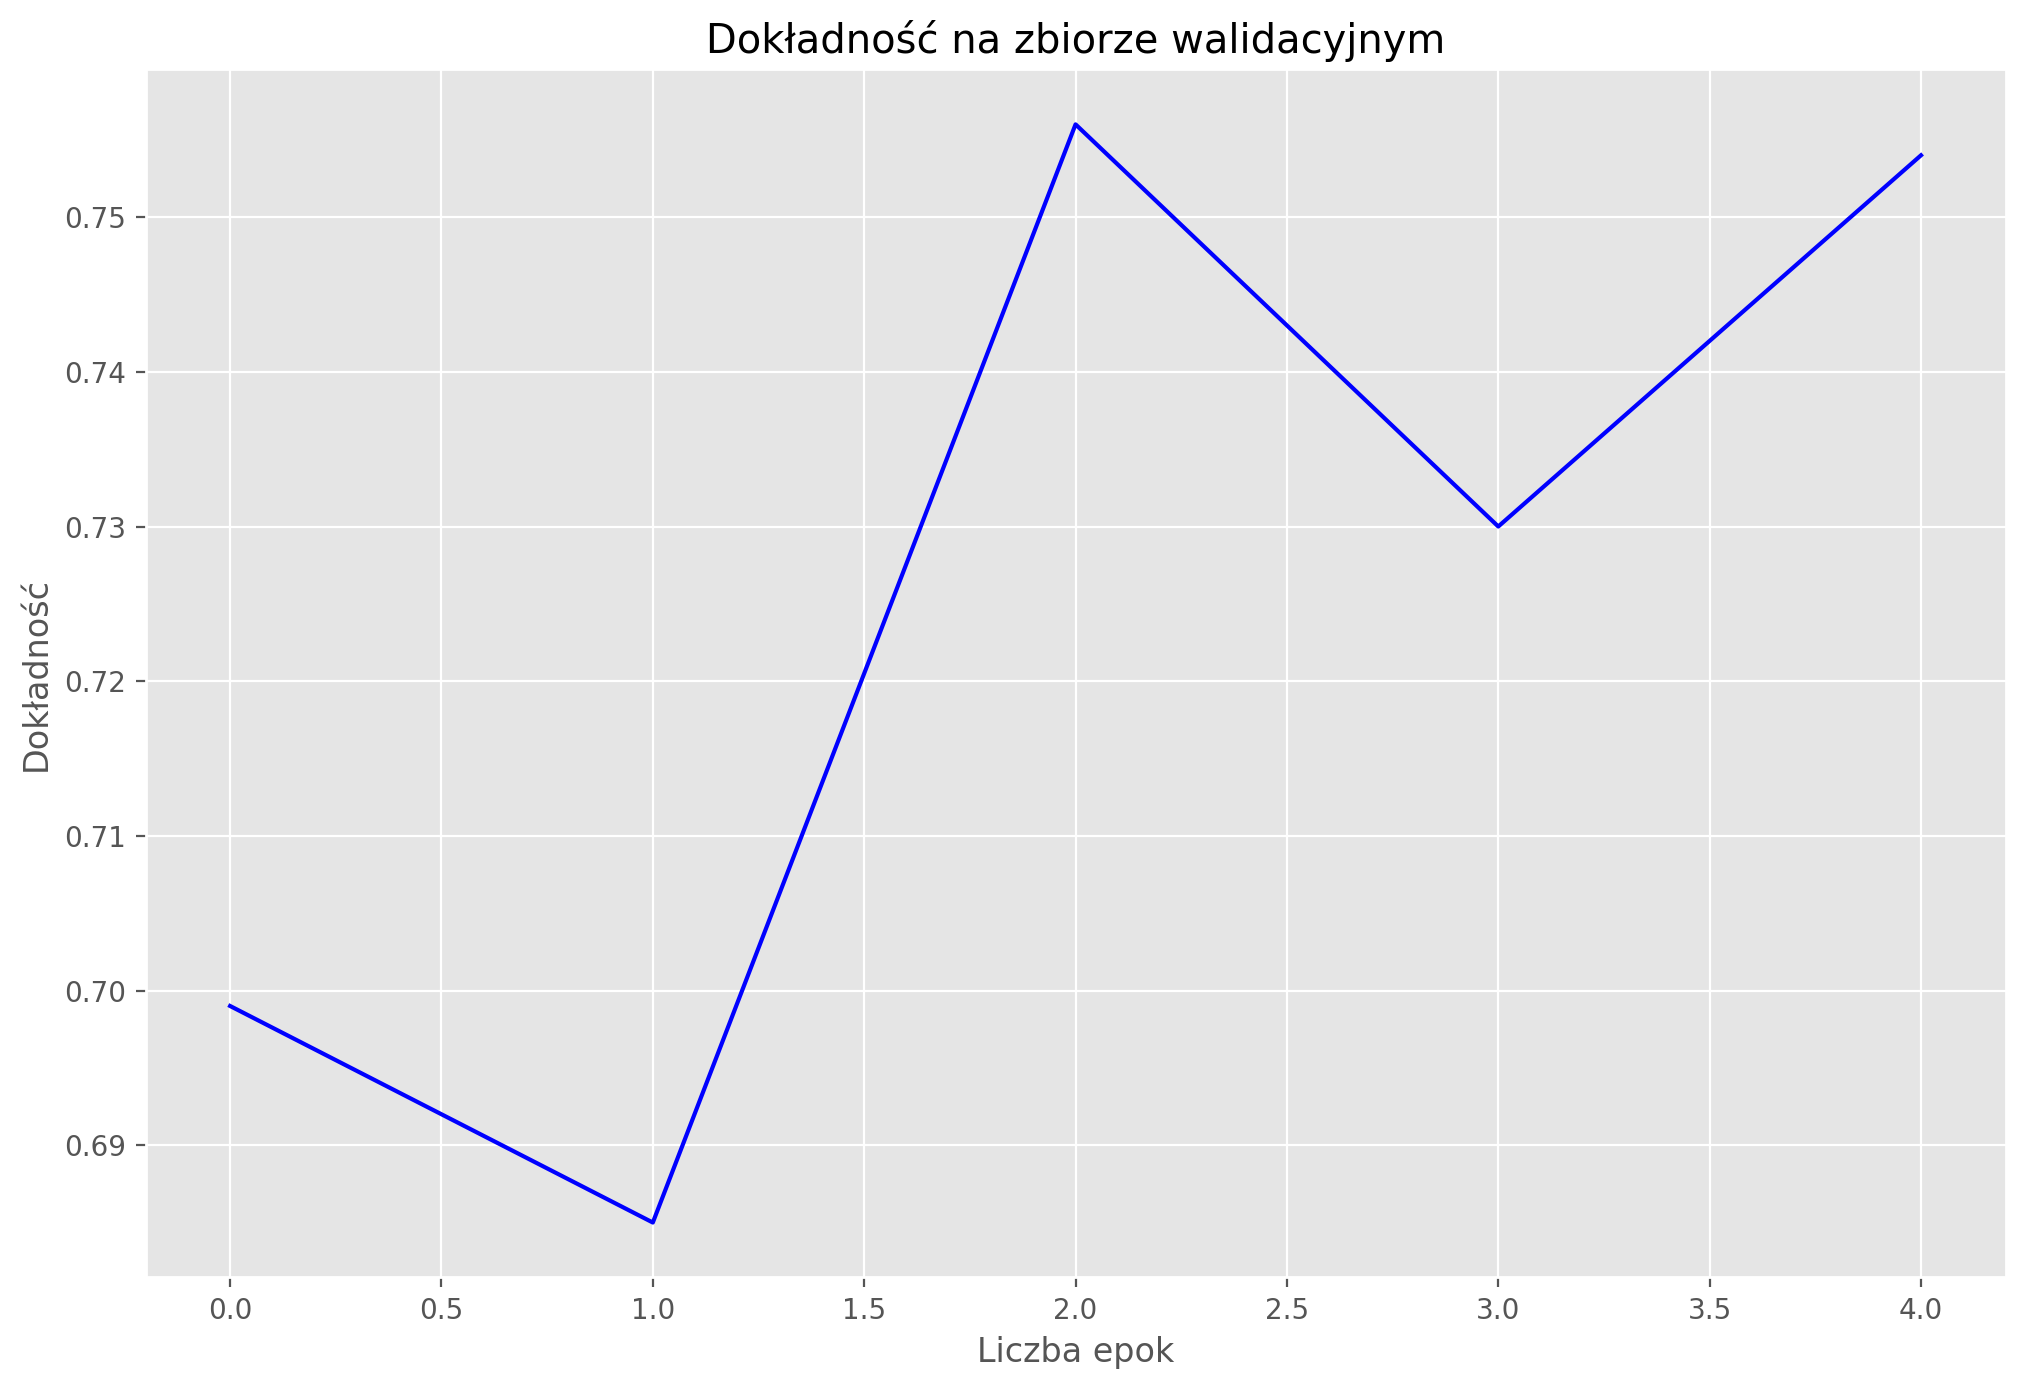

In [16]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 8), dpi=200)
plt.rcParams['axes.facecolor'] = 'white'
plt.style.use('ggplot')
plt.plot(range(5), hist, 'b-')
plt.xlabel('Liczba epok')
plt.ylabel('Dokładność')
plt.title('Dokładność na zbiorze walidacyjnym')
plt.savefig('resnet_cifar.png')
plt.show()

In [14]:
model_ft.eval()
predictions = []

with torch.no_grad():
    for images, labels in dataloaders_dict["val"]:
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted)

predictions = torch.cat(predictions, dim=0)
print(predictions)

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 3, 9, 8, 5, 7, 8, 6, 7, 0, 4, 1,
        5, 7, 3, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 9, 9, 5, 0, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 6, 3, 8, 8, 6, 3, 3, 3, 7, 3, 6, 3, 6, 2, 1, 0, 3, 7, 2, 6,
        8, 8, 9, 2, 9, 3, 5, 8, 8, 1, 1, 7, 3, 7, 2, 0, 8, 9, 8, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 4, 6, 3, 1, 1, 3, 6, 8, 6, 6, 0, 6, 2, 1, 3, 0, 9, 3, 3,
        8, 3, 1, 2, 8, 2, 8, 3, 3, 0, 4, 1, 8, 9, 0, 2, 9, 7, 2, 9, 6, 5, 6, 7,
        8, 3, 6, 5, 5, 3, 8, 9, 6, 9, 0, 3, 3, 9, 3, 4, 0, 1, 6, 6, 0, 4, 8, 4,
        5, 8, 9, 6, 9, 8, 9, 9, 3, 7, 3, 8, 0, 5, 6, 6, 5, 8, 4, 3, 3, 8, 5, 8,
        7, 1, 4, 2, 8, 8, 7, 8, 5, 8, 8, 9, 1, 3, 0, 6, 7, 9, 3, 8, 5, 9, 8, 0,
        7, 9, 8, 2, 7, 5, 9, 4, 3, 9, 6, 4, 3, 6, 5, 1, 3, 8, 8, 0, 4, 9, 5, 7,
        1, 1, 8, 9, 0, 6, 1, 9, 2, 6, 5, 3, 9, 1, 4, 8, 3, 0, 0, 9, 9, 1, 5, 3,
        0, 8, 6, 4, 7, 2, 2, 3, 6, 3, 8, 5, 8, 3, 4, 3, 9, 0, 6, 1, 9, 9, 1, 8,
        7, 9, 1, 2, 4, 1, 3, 2, 6, 0, 0,